## Problem 8.1: A hierarchical model for cell viability on biomaterials, 60 points

**Note:** *This problem deals with unpublished research. The authors kindly donated the data set and shared their research and ask that you not disseminate this problem nor its data set beyond the context of this course.*

The [Kornfield lab](http://kornfield.caltech.edu) at Caltech does interesting work at the interfaces of polymer chemistry, polymer physics, and therapeutics with biomaterials. As they develop interesting materials that will interface with the human body, they test to see how different cell types will respond to the material. They are currently developing a material called PLA and did the following assay. They exposed [human umbilical vein endothelial cells](https://en.wikipedia.org/wiki/Human_umbilical_vein_endothelial_cell) (HUVEC) to their PLA material for 24 hours. They then tested the viability of the cells by performing a metabolic assay. The subject the cells to WST-1, a tetrazolium salt. In viable cells, mitochondrial dehydrogenases cleave WST-1, which gives a product that absorbs light in the 450 nm range. This allows for optical quantification of cell viability.

Zach Shao and his coworkers in the Kornfield lab performed this assay on three different varieties of their PLA material. They also performed a control experiment where the cells were grown up absent of any of the PLA material. They also did a negative control experiment in which the cells were treated with a detergent that distrupts the cell membrane. The results from the assay are given in arbitrary units, but those units are consistent throughout the experiments. You can download the data set [here](http://bebi103.caltech.edu/2018_protected/data/shao_et_al_wst-1_assay.csv).

**a)** Perform some exploratory data analysis to investigate the data set.

We will begin by importing the tools of the trade.

In [1]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import bebi103
import pystan

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat
# Pevent bulky altair plots
alt.data_transformers.enable('json')

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.plotting
# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

Loading BokehJS ...

We now import and tidy up the data:

In [2]:
df = pd.read_csv('../data/shao_et_al_wst-1_assay.csv', comment='#')
# Change "One" to 1 in Experiment column. 
col_names = {"One":1, "Two":2, "Three":3}
arr = df["Experiment"].values
exp = np.zeros(len(arr), dtype=int)
for i in range(0, len(arr)):
    exp[i] = col_names[arr[i]]
df["Experiment"] = exp
# Peek at data
df.head()

,Treatment,Experiment,assay_result
0,Control,1,1.45945
1,Control,1,1.51035
2,Control,1,1.80045
3,Control,1,1.83745
4,PLA_1,1,1.42015


and then produce a simple plot using altair.

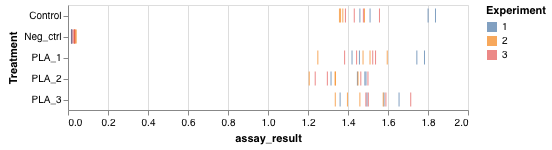

In [3]:
alt.Chart(df).mark_tick().encode(
        x='assay_result:Q',
        y='Treatment:N',
        color = alt.Color('Experiment:N'),
    )

From this plot, we can clearly see that the negative control cells have nearly zero absorbance, but each PLA is not clearly better or worse than the other. Due to exceptionally low negative controls, I will omit them from the following ECDFs. 

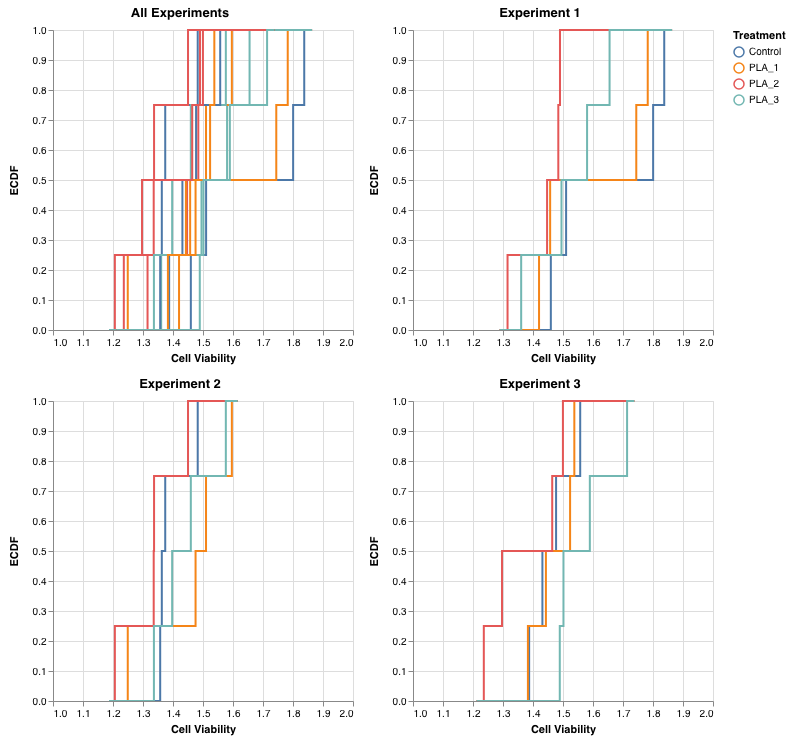

In [4]:
def make_ecdf(bool_index, title):
    c = altcat.catplot(data=df_no_control.loc[bool_index,:],
               mark='line',
               encoding=dict(x=alt.X('assay_result:Q',
                                     scale=alt.Scale(
                                           domain=(1, 2),
                                           clamp=True),
                                    title = "Cell Viability"),
                             color = alt.Color('Treatment:N', title='Treatment')),
               transform='ecdf'
              ).properties(height=300,
                           width=300,
                           title = title)
    return c
df_no_control = df[df["Treatment"] != "Neg_ctrl"]
# Segregate data by experiment
E1 = df_no_control['Experiment'] == 1
E2 = df_no_control['Experiment'] == 2
E3 = df_no_control['Experiment'] == 3

(((make_ecdf(E1, "All Experiments") 
 + make_ecdf(E2, "All Experiments") 
 + make_ecdf(E3, "All Experiments")) 
 | make_ecdf(E1, "Experiment 1")) 
 &(make_ecdf(E2, "Experiment 2") 
 | make_ecdf(E3, "Experiment 3")))

PLA 2 seems to be the worst in terms of cell viability, but the best material seems to vary between experiments. We will now transition to hierarchical modeling. 

**b)** Construct a hierarchical model describing the results. Because you are not familiar with this kind of experiment, it will be hard to construct priors. In doing so, assume that a typical assay value for a reasonably viable group of cells is about unity, and the typical baseline (absence of viable cells) does not go much beyond 0.05. Note that constructing the hierarchical model involes performing prior predictive checks. Note also that you may need to consider some pragmatic tradeoffs when doing your prior predictive checks (such as occasional unphysical results). 

Changing name of key: `my_dict[new_key] = my_dict.pop[old_key]`

Merging:  `dictionary_3 = {**dict_1, **dict_2}`

Since the negative control was so successful, we will omit it from the analysis. Fluorescence units are arbitrary, and thus even a small correction will not be informative.

We decided to model the data obtained from each plastic (or lackthereof) using 3 hyperparameters: 

1. $\theta_H$: The average fluoresence for a given type of plastic.
2. $\sigma_H$: The standard deviation of fluoresence values obtained on a given day.
3. $\sigma_P$: The standard deviation of the average fluorescence value on a given day from the total average fluorescence for the given type of plastic. 

We have three experients, and I will denote that a number is for a particular experiment by using the subscript $i$, where $1 \leq i \leq 3$. Our model is as follows:
\begin{align}
\theta_H \sim & \, \text{LogNorm}(0.25, 0.50)\\
\sigma_H \sim & \, \text{Half-Norm}(0, 0.5)\\
\sigma_P \sim & \, \text{Half-Norm}(0, 0.5)\\
\theta_i \sim & \, \text{Norm}(\theta_H, \sigma_P)\\
\text{fluorescence}_i \sim & \, \text{Norm}(\theta_i, \sigma_H)
\end{align}
This paricular choice of model might seem unintuitive. Originally we wanted to model the standard deviation of each experiment individually, rather than just model with the two deviations shown. However, we recalled Justin Bois stating in lecture that this approach was not optimal. Thus, we chose to model our standard deviations differently. Note that the theta hyperparameter was chosen to be log-normal specifically so that we get positive fluorescence. 

We will now write a generative model in Stan in order to do a prior-predictive check. 

In [5]:
sm = bebi103.stan.StanModel(file='./8.1_prior_pred.stan')
print(sm.model_code)

Using cached StanModel.
data {
    int N;
    int num_exps;
    int experiment[N];
}

generated quantities {
    real<lower=0> theta_H;
    real<lower=0> sigma_H;
    real<lower=0> sigma_P;
    vector[num_exps] theta;
    vector[N] fluorescence;
    
    // Draw parameters
    theta_H = lognormal_rng(0.25, 0.5); 
    // Here, fabs is used to draw from the half-normal distribution.
    sigma_H = fabs(normal_rng(0, 0.5));
    sigma_P = fabs(normal_rng(0, 0.5));
    
    for (i in 1:num_exps)
    { 
        theta[i] = normal_rng(theta_H, sigma_P);
    }
    for (i in 1:N) 
    {
        fluorescence[i] = normal_rng(theta[experiment[i]], sigma_H);
    }
}



Now we use this model to generate data.

In [6]:
# I will only generate data for one type of PLA. Since we are not specifiying
# any differences based on the PLA, this is fine for a prior predictive check. 
df_generative = df[df["Treatment"]=="PLA_1"]
# Synthesize the data dictionary required for input
num_exps = len(np.unique(df_generative["Experiment"].values)) # this is just 3
experiment = df_generative["Experiment"].values
N = len(experiment)
data = dict(N=N,
            num_exps=num_exps,
            experiment=experiment)
# Generate samples
samples_gen = sm.sampling(data=data,
                          algorithm='Fixed_param',
                          warmup=0,
                          chains=1,
                          iter=100)
# Store samples in a dataframe
df_gen = bebi103.stan.to_dataframe(samples_gen, diagnostics=False)
df_gen.head()

,chain,chain_idx,warmup,theta_H,sigma_H,sigma_P,theta[1],theta[2],theta[3],fluorescence[1],...,fluorescence[4],fluorescence[5],fluorescence[6],fluorescence[7],fluorescence[8],fluorescence[9],fluorescence[10],fluorescence[11],fluorescence[12],lp__
0,1,1,0,0.585573,0.318278,0.742001,1.303908,-0.113059,0.377196,0.739917,...,1.170112,0.151630,0.170725,0.068697,0.346021,-0.261839,0.543194,0.772641,0.669614,0.0
1,1,2,0,1.959079,0.072607,0.034427,1.924101,1.927529,1.991691,1.885713,...,1.854392,1.913506,2.015680,1.837381,1.966233,2.024730,1.975785,1.814527,1.884968,0.0
2,1,3,0,1.644953,0.039599,0.227603,1.888562,1.431571,1.656501,1.859423,...,1.873132,1.406209,1.436968,1.456834,1.439215,1.666230,1.605488,1.631614,1.645327,0.0
3,1,4,0,2.153240,0.353320,0.339699,2.289107,1.876051,2.144900,2.291879,...,2.427748,1.800730,1.475450,1.481480,1.718656,1.622219,1.851872,2.173593,2.382755,0.0
4,1,5,0,2.151528,0.070576,0.735438,2.372224,2.828840,2.467205,2.470589,...,2.427214,2.876677,2.850715,2.723023,2.949093,2.390516,2.527429,2.473249,2.515845,0.0


Sampling worked. I'd like to plot, but to do this I need to know which fluorescence values correspond to which experiment. Let's peek at the experiment array, and then sort the plots accordingly. 

In [7]:
experiment

array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

In [8]:
df_exp1 = df_gen[["fluorescence[%i]"%i for i in range(1, 5)]]
df_exp2 = df_gen[["fluorescence[%i]"%i for i in range(5, 9)]]
df_exp3 = df_gen[["fluorescence[%i]"%i for i in range(9, 13)]]
df_exp3.head()

,fluorescence[9],fluorescence[10],fluorescence[11],fluorescence[12]
0,-0.261839,0.543194,0.772641,0.669614
1,2.024730,1.975785,1.814527,1.884968
2,1.666230,1.605488,1.631614,1.645327
3,1.622219,1.851872,2.173593,2.382755
4,2.390516,2.527429,2.473249,2.515845


Now that we have sorted generated data by experiment, we can make reasonable plots. At this point, each plot should appear nearly identical, but I will plot all three for the sake of a sanity check. 

In [9]:
dfs = [df_exp1, df_exp2, df_exp3]
for i in range(1, 4):
    name = "Experiment %i" % i
    dataframe = dfs[i-1]
    p = bebi103.viz.ecdf(dataframe.iloc[0].values, 
                         formal=True, 
                         line_width=0.5, 
                         x_axis_label='Fluorescence',
                         title = name)
    for j in range(1, len(df_gen)):
        p = bebi103.viz.ecdf(dataframe.iloc[j].values, 
                         formal=True, 
                         line_width=0.5, 
                         x_axis_label='Fluorescence',
                         p=p)
    p.x_range = bokeh.models.Range1d(-2, 5)
    bokeh.io.show(p)

The prior predictive check seems very reasonable! This means that I can code up the actual model in stan and draw samples using Marcov Chain Monte Carlo!

In [10]:
sm_hier = bebi103.stan.StanModel(file='./8.1_mcmc.stan')
print(sm.model_code)

Using cached StanModel.
data {
    int N;
    int num_exps;
    int experiment[N];
}

generated quantities {
    real<lower=0> theta_H;
    real<lower=0> sigma_H;
    real<lower=0> sigma_P;
    vector[num_exps] theta;
    vector[N] fluorescence;
    
    // Draw parameters
    theta_H = lognormal_rng(0.25, 0.5); 
    // Here, fabs is used to draw from the half-normal distribution.
    sigma_H = fabs(normal_rng(0, 0.5));
    sigma_P = fabs(normal_rng(0, 0.5));
    
    for (i in 1:num_exps)
    { 
        theta[i] = normal_rng(theta_H, sigma_P);
    }
    for (i in 1:N) 
    {
        fluorescence[i] = normal_rng(theta[experiment[i]], sigma_H);
    }
}



The model compiled! Let's now sample from the posterior. 

In [11]:
# I will start by sampling the distribution for the first PLA
df_1 = df[df["Treatment"]=="PLA_1"]
# Synthesize the data dictionary required for input
num_exps = len(np.unique(df_1["Experiment"].values)) # this is just 3
experiment = df_1["Experiment"].values
N = len(experiment)
assay_res_1 = df_1["assay_result"].values
data = dict(N=N,
            num_exps=num_exps,
            experiment=experiment,
            fluorescence = assay_res_1)
samples_hier = sm_hier.sampling(data=data, 
                                control=dict(adapt_delta = .9999999),
                                warmup=1000, 
                                iter=10000, 
                                thin=5)
bebi103.stan.check_all_diagnostics(samples_hier)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
28 of 7200 (0.3888888888888889%) iterations ended with a divergence.
  Try running with larger adapt_delta to remove divergences.
0 of 7200 (0.0%) iterations saturated the maximum tree depth of 10.
E-BFMI indicated no pathological behavior.


4

Posterior-predictive-Check

In [12]:
# Plot Data
for num in range(1, 4):
    name = "Experiment %i" % num
    dataframe = df_1[df_1["Experiment"]==num]
    if num == 1:
        p = bebi103.viz.ecdf(dataframe["assay_result"].values, 
                             formal=True, 
                             line_width=2, 
                             x_axis_label='Fluorescence', 
                             color = 'red')
    else:
        p = bebi103.viz.ecdf(dataframe["assay_result"].values, 
                             formal=True, 
                             line_width=2, 
                             x_axis_label='Fluorescence',
                             color = 'red',
                             p=p)

# Plot posterior predictive check
df_fl_1_ppc = bebi103.stan.extract_array(samples_hier, 'fluorescence_ppc')
for chain_index in range(1, 25):
    for chain in range(1, 5):
        df_plot = df_fl_1_ppc[df_fl_1_ppc["chain"]==chain]
        df_plot = df_plot[df_plot["chain_idx"]==chain_index]
        fluorescence = df_plot["fluorescence_ppc"].values
        
        # Plot an ecdf for each experiment, of which there are three in a single sample.
        for i in range(0, 3):
            to_plot = fluorescence[(i * 4) : (i * 4 + 4)]
            p = bebi103.viz.ecdf(to_plot, formal=True, line_width = 0.13, p=p)
bokeh.io.show(p)

This seems like a great model!!

**c)** The authors are interested in the ratio of the PLA assay results to control. Using your hierarchical model, perform parameter estimation to compare the ratios PLA-1/control, PLA-2/control, and PLA-3/control. *Hint*: When you do not have much data, such as is the case here, using a noncentered parametrization is often very important.